In [5]:
# for vectors manipulation
import numpy as np

# for plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# visualize plots in the jupyter notebook
# check more https://goo.gl/U3Ai8R
%matplotlib inline

# for generating random values
import random

# for representing things like card value or colors
from enum import Enum  

# for copying python objects
import copy

#for logging 
import logging
#logging.basicConfig(level=logging.DEBUG)


In [6]:
def plot_pls(title, V_Plot):
    generate_gif = False
    fig = plt.figure(title, figsize=(10, 5))                               #From Online

    # explanation about this line: https://goo.gl/LH5E7i
    ax = fig.add_subplot(111, projection='3d')

    if generate_gif:
        print('gif will be saved as %s' % title)
        
    def plot_frame(ax):
        # min value allowed accordingly with the documentation is 1
        # we're getting the max value from V dimensions
        min_x = 1
        max_x = V_Plot.shape[1]
        min_y = 1
        max_y = V_Plot.shape[0]

        # creates a sequence from min to max
        x_range = np.arange(min_x, max_x)
        y_range = np.arange(min_y, max_y)

        # creates a grid representation of x_range and y_range
        X, Y = np.meshgrid(x_range, y_range)

        # get value function for X and Y values
        def get_stat_val(x, y):
            return V_Plot[y, x]
        Z = get_stat_val(X, Y)

        # creates a surface to be ploted
        # check documentation for details: https://goo.gl/etEhPP
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Sum')
        ax.set_zlabel('Value')
        return ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, 
                               linewidth=0, antialiased=False)

    def animate(frame):
        # clear the plot and create a new surface
        ax.clear()
        surf = plot_frame(ax)
        # if we're going to generate a gif we need to train a couple of times
        if generate_gif:
            i = agent.iterations
            # cool math to increase number of steps as we go
            if train_steps is None:
                step_size = int(min(max(1, agent.iterations), 2 ** 16))
            else:
                step_size = train_steps

            agent.train(step_size)
            plt.title('%s MC score: %s frame: %s' % (title, float(agent.wins)/agent.iterations*100, frame))
        else:
            plt.title(title)

        fig.canvas.draw()
        return surf
    
    ani = animation.FuncAnimation(fig, animate, 32, repeat=False)

    # requires gif writer
    if generate_gif:
        ani.save(title + '.gif', writer='imagemagick', fps=3)
    else:
        plt.show()
        
    return fig    

In [7]:
def plot_lambdas():
    lambdas = [0, 0.33, 0.5, 0.66, 1]
    lambdas = [it/10.0 for it in range(0, 11, 1)]
    episodesRange = range(1, 99999, 1011)
    mseFig, axs = plt.subplots(3, 2, sharex='col', sharey='row',
                            gridspec_kw={'hspace': 0, 'wspace': 0},figsize=(17,10))
    (ax1, ax2), (ax3, ax4), (ax5, ax6) = axs

    ax1.plot(episodesRange, all_mse_values[0], label='MSE for λ = 0')  
    ax2.plot(episodesRange, all_mse_values[1], label='MSE for λ = 0.33')  
    ax3.plot(episodesRange, all_mse_values[2], label='MSE for λ = 0.5')  
    ax4.plot(episodesRange, all_mse_values[3], label='MSE for λ = 0.66')  
    ax5.plot(episodesRange, all_mse_values[4], label='MSE for λ = 1')  

    for xy in zip(episodesRange, all_mse_values[0]): 
        if (xy[0] % 25 == 0):
            ax1.annotate('(%s, %.4f)' % xy, xy=xy, textcoords="offset points", xytext=(0,10)) 
    for xy in zip(episodesRange, all_mse_values[1]): 
        if (xy[0] % 25 == 0):
            ax2.annotate('(%s, %.4f)' % xy, xy=xy, textcoords="offset points", xytext=(0,10))
    for xy in zip(episodesRange, all_mse_values[2]): 
        if (xy[0] % 25 == 0):
            ax3.annotate('(%s, %.4f)' % xy, xy=xy, textcoords="offset points", xytext=(0,10))
    for xy in zip(episodesRange, all_mse_values[3]): 
        if (xy[0] % 25 == 0):
            ax4.annotate('(%s, %.4f)' % xy, xy=xy, textcoords="offset points", xytext=(0,10))
    for xy in zip(episodesRange, all_mse_values[4]): 
        if (xy[0] % 25 == 0):
            ax5.annotate('(%s, %.4f)' % xy, xy=xy, textcoords="offset points", xytext=(0,10))

    ax4.set_xlabel('Episode number')

    ax1.set_ylabel('MSE : λ = 0')  
    ax2.set_ylabel('MSE : λ = 0.33')  
    ax3.set_ylabel('MSE : λ = 0.5')  
    ax4.set_ylabel('MSE : λ = 0.66')  
    ax5.set_ylabel('MSE : λ = 1')  

    mseFig.tight_layout()
    axs[2][1].set_axis_off()
    mseFig.suptitle('MSE vs Episode')
    # mseFig.savefig("MSE vs Episode", bbox_inches='tight')

In [8]:
def plot_mse_stuff(given_mse_vals, lambdas):
    mseFig, ax = plt.subplots()  
    ax.plot(lambdas, given_mse_vals, label='MSE')  
    ax.set_xlabel('Lambda Value')  
    ax.set_ylabel('MSE')  
    ax.set_title("LFA : MSE vs Lambda")  
    ax.legend()  
    return mseFig

In [9]:
MC_V = np.zeros([22, 11])
MC_Q = np.zeros([22, 11, 2])
TD_V = np.zeros([22, 11])
TD_Q = np.zeros([22, 11, 2])
LFA_V = np.zeros([22, 11])
LFA_Q = np.zeros([22, 11, 2])
all_mse_values =[]

In [10]:
class Action(Enum):
    hit = 0
    stick = 1 

In [11]:
class Colour(Enum):
    red = 0
    black = 1

In [12]:
class Deck:
    def __init__(self, seed):
        random.seed(seed)
    
    @staticmethod
    def draw_card():
        card = Card(random.randint(1,10), random.randint(1,3))
        logging.debug("New card : %s", card)
        return card
    
    @staticmethod
    def draw_first_card():
        return Card(random.randint(1,10), 2)

In [13]:
class Card:
    def __init__(self, number, colour):
        self.number = number
        if colour == 1:
            self.colour = Colour.red
            self.value = -number
        else:
            self.colour = Colour.black
            self.value = number
            
    def __str__(self):
        string = 'number : ' + str(self.number) + '\n colour : ' + str(self.colour)
        return string

In [14]:
class State:
    def __init__(self, deck):
        self.player_sum = deck.draw_first_card().value
        self.card = deck.draw_first_card()
        self.is_Terminal = False

In [98]:
class Env:
    def __init__(self, seed):
        self.deck = Deck(seed)
    
    def step(self, s, a):
        dealer_card = s.card                  #want to make this an int, but criteria specify it should be a card
        player_sum = s.player_sum
        next_state = copy.copy(s)
        
        next_state.is_Terminal = False
        r = 0
        
        if (a == Action.hit.value):
            new_card = self.deck.draw_card()
            next_state.player_sum += new_card.value
            logging.debug("New value is :", next_state.player_sum)
            if (self.is_bust(next_state.player_sum)):
                next_state.is_Terminal = True
                r = -1
        else:
            next_state.is_Terminal = True
            r = self.play_remainder(player_sum, dealer_card)

        return next_state, r
    
    @staticmethod
    def is_bust(sum):
        if (sum > 21 or sum < 1):
            logging.debug("BUST!")
            return True
        return False
    
    def play_remainder(self, player_sum, dealer_card):
        logging.debug("\n\nPlayer sum = %i, playing out:", player_sum)
        
        dealer_sum = dealer_card.value
        while (dealer_sum < 17):
            dealer_sum += self.deck.draw_card().value
            logging.debug("\nDealer value :", dealer_sum)
            if (self.is_bust(dealer_sum)):
                return 1
        if (dealer_sum < player_sum):
            return 1
        if (dealer_sum == player_sum):
            return 0
        return -1

In [16]:
class Player:
    def __init__(self, gamma):
        self.gamma = gamma
        self.Q = self.get_clear_tensor()
        self.V = np.zeros([22, 11])
            
        self.N_0 = 100
        self.N_sa = self.get_clear_tensor()
                
    def get_clear_tensor(self):         #Used help
        return np.zeros((22, 11, 2))
    
    def get_learning_rate(self, state, action):     
        player_sum = state.player_sum
        dealer_sum = state.card.value
        chosen_action = action.value
        N_sat = self.N_sa[player_sum, dealer_sum, chosen_action]
        learning_rate = 1/N_sat
        return learning_rate
   
    def act_eps_greedy(self, current_state):
        p_sum = current_state.player_sum
        d_sum = current_state.card.value
        N_st = sum(self.N_sa[p_sum, d_sum, :])
        
        self.eps_t = self.N_0/(self.N_0+N_st)
        
        if random.uniform(0, 1) < self.eps_t:
            if (random.randint(0,1)):
                action = Action.stick
            else:
                action = Action.hit
        else:
            if (np.argmax(self.Q[p_sum, d_sum, :])):
                action = Action.stick
            else:
                action = Action.hit

        return action
            
    @staticmethod
    def act_hard_coded(current_state):
        if current_state.player_sum <=17:
            return Action.hit
        return Action.stick
                       
    def get_value_function(self, deck):                   #From online
        for i in range(1, 22):
            for j in range(1, 11):
                s = State(deck)
                s.player_sum = i
                s.card.value = j
                self.V[i][j] = np.max(self.Q[s.player_sum][s.card.value])
        return self.V
        
    def get_Q_at(self, state, action):
        player_sum = state.player_sum
        dealer_sum = state.card.value
        chosen_action = action.value
        return self.Q[player_sum][dealer_sum][chosen_action].copy()

In [17]:
class MC_Player(Player):
    def __init__(self, gamma):
        print("MC_Player init")
        Player.__init__(self, gamma)
        
    def update_MC(self, states, actions, rewards):
        for x in range(len(states)):
            p_sum = states[x].player_sum
            d_sum = states[x].card.value
            action = actions[x].value
           
            Gt = 0
            for i in range(x, len(states)):
                Gt += rewards[i]*(self.gamma**i)
                
            self.N_sa[p_sum][d_sum][action] += 1
            error = Gt - self.Q[p_sum][d_sum][action]
            self.Q[p_sum][d_sum][action] += self.get_learning_rate(states[x], actions[x]) * error

In [18]:
def MC_Eval(episode_count, env):
    
    print("In MC Eval")
    gamma = 1
    mc_wins = 0
    
    player = MC_Player(gamma)
    
    for mc_episode in range(episode_count):

        all_states = []
        all_actions = []
        all_rewards = []
        s = State(env.deck)
        
        while not s.is_Terminal:
            action = player.act_eps_greedy(s)

            next_state, r = env.step(s, action)
            
            all_states.append(s)
            all_actions.append(action)
            all_rewards.append(r)

            s = next_state
        
        #Episode complete
        if (r == 1):
            mc_wins += 1
        player.update_MC(all_states, all_actions, all_rewards)
        
        if (mc_episode > 30 and mc_episode < 100 and mc_episode != 0):
            print("MC Episode ", mc_episode, "wins/iterations ", (mc_wins/mc_episode * 100))
        if (mc_episode % 100000 == 0 and mc_episode != 0):
            print("Episode ", mc_episode, "wins/iterations ", (mc_wins/mc_episode * 100))


    return player.get_value_function(env.deck), player.Q

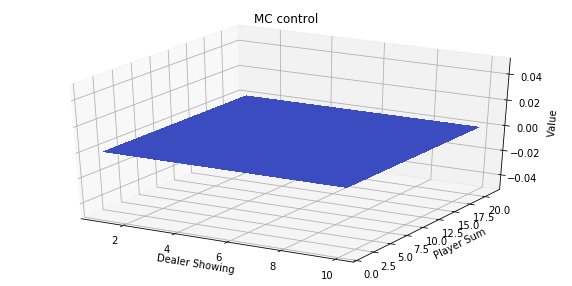

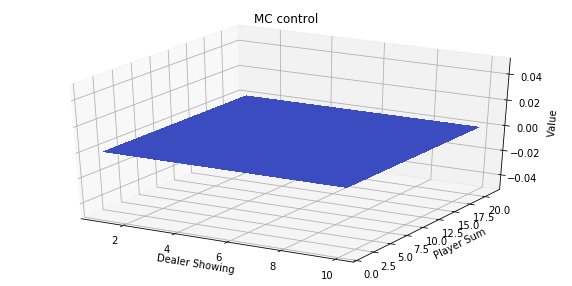

In [19]:
plot_pls("MC control", MC_V)
#fig.savefig("MC-N0=100, 100000Episodes")

In [20]:
class TD_Player(Player):
    def __init__(self, gamma, td_Lambda):
        print("TD_Player init")
        Player.__init__(self, gamma)
        self.td_lambda = td_Lambda
        self.E_trace = self.get_clear_tensor()
        
    def update_TD(self, r, state, action, next_state, next_action):
        Q_Current = self.get_Q_at(state, action)
        
        if (next_state.is_Terminal):
            delta = r - Q_Current
        else:
            Q_Next = self.get_Q_at(next_state, next_action)
            delta = r + self.gamma*Q_Next - Q_Current
        
        self.E_trace[state.player_sum][state.card.value][action.value] +=1
        
        alpha = self.get_learning_rate(state, action)
        update_q = alpha * delta * self.E_trace
        self.Q += update_q
        
        self.E_trace *= (self.gamma * self.td_lambda)
        
    def mean_squared_error(self, Q_true):
        return np.sum(np.square(self.Q.copy() - Q_true.copy()))

In [21]:
def TD_Eval(episode_count, env, Q_true, lambdaVal):
    
    print("In td eval")
    gamma = 1
    td_wins = 0
    
    mse_values = []
    TDplayer = TD_Player(gamma, lambdaVal)
    
    for td_episode in range(episode_count):              
        TDplayer.E_trace = TDplayer.get_clear_tensor()
        s = State(env.deck)
        
        #choose first action
        action = TDplayer.act_eps_greedy(s)
        next_action = action
        
        while not s.is_Terminal:
            TDplayer.N_sa[s.player_sum][s.card.value][action.value] += 1
            next_state, r = env.step(s, action)
            
            if (not next_state.is_Terminal):
                next_action = TDplayer.act_eps_greedy(next_state)
            
            TDplayer.update_TD(r, s, action, next_state, next_action)
            
            s, action = next_state, next_action
        #Episode complete
        if (r == 1):
            td_wins += 1

        if (td_episode > 30 and td_episode < 100 and td_episode != 0):
            print("TD Episode ", td_episode, "wins/iterations ", (td_wins/td_episode * 100))
        if (td_episode % 100000 == 0 and td_episode != 0):
            print("Episode ", td_episode, " wins/iterations ", (td_wins/td_episode * 100))
            mse = TDplayer.mean_squared_error(Q_true) / (21*10*2)
            mse_values.append(mse)
            print("For lambda ", lambdaVal, " mean-squared error : ", mse)

    return TDplayer.get_value_function(env.deck), TDplayer.Q.copy(), mse_values

In [22]:
# MC time:  39.40438747406006
# Total time taken:  117.75097727775574

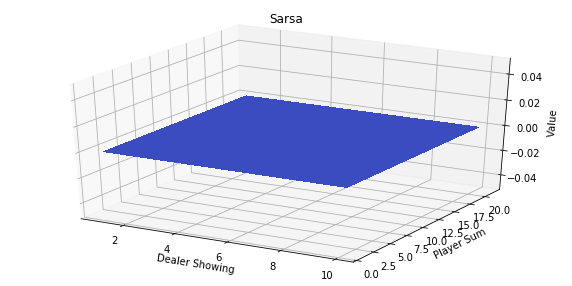

In [23]:
fig = plot_pls("Sarsa", TD_V)
#fig.savefig("TD-N0=100, Lambda = 1, 1000000 Episodes")

In [24]:
class LFA_Player(Player):
    def __init__(self, gamma, td_Lambda):
        Player.__init__(self, gamma)
        self.td_lambda = td_Lambda
        self.eps_t=0.05
        
        self.features=36
        self.weights=self.get_clear_feature_tensor()
        self.E_trace = self.get_clear_feature_tensor()
        self.player_sum = [[1, 6], [4, 9], [7, 12], [10, 15], [13, 18], [16, 21]]
        self.dealer_sum = [[1, 4], [4, 7], [7, 10]]
        
    def get_clear_feature_tensor(self):  
        return np.zeros(self.features)
    
    def get_learning_rate(self, state, action):
        return 0.01
    
    def act_eps_greedy(self, current_state):
        p_sum = current_state.player_sum
        d_sum = current_state.card.value
        if random.uniform(0, 1) < self.eps_t:
            if (random.randint(0,1)):
                action = Action.stick
            else:
                action = Action.hit
        else:
            if (np.argmax([self.get_Q_at(current_state,Action.hit), self.get_Q_at(current_state,Action.stick)])):
                action = Action.stick
            else:
                action = Action.hit
        return action
                
    def get_Q_at(self, state, action):
        return np.dot(self.get_phi_at(state,action), self.weights)
    
    def get_phi_at(self, state, action):
        phi = self.get_clear_feature_tensor()
        phi_p_idx = self.get_player_feature_index(state) 
        phi_d_idx = self.get_dealer_feature_index(state)

        for phi_p in phi_p_idx:
            for phi_d in phi_d_idx:
                phiIndex = self.get_feature_tensor_index_for(phi_p, phi_d, action.value)
                phi[phiIndex] = 1
        return phi
                
    def get_player_feature_index(self, state):
        p_idx = []
        for idx, (lowerBound, upperBound) in enumerate(self.player_sum):
            if ( lowerBound <= state.player_sum <= upperBound):
                p_idx.append(idx)
        return p_idx
                
    def get_dealer_feature_index(self, state):
        d_idx = []
        for idx, (lowerBound, upperBound) in enumerate(self.dealer_sum):
            if ( lowerBound <= state.card.value <= upperBound):
                d_idx.append(idx)
        return d_idx
                
    def get_feature_tensor_index_for(self, player_idx, dealer_idx, action_idx):
        return player_idx + dealer_idx*6 + action_idx*18
    
    def mean_squared_error(self, Q_true, deck):
        Q = self.get_clear_tensor() 
        for i in range(1, 22):
            for j in range(1, 11):
                for k in range(0, 1):
                    s = State(deck)
                    s.player_sum = i
                    s.card.value = j
                    if (k):
                        a = Action.stick
                    else:
                        a = Action.hit
                    Q[i,j,k] = self.get_Q_at(s, a)
        return np.sum(np.square(Q.copy() - Q_true.copy()))
    
    def get_value_function(self, deck):
        for i in range(1, 22):
            for j in range(1, 11):
                s = State(deck)
                s.player_sum = i
                s.card.value = j
                self.V[i][j] = np.max([self.get_Q_at(s, Action.hit), self.get_Q_at(s, Action.stick)])
        return self.V
                
    def update_LFA(self, r, state, action, next_state, next_action):
        Q_current = self.get_Q_at(state, action)
                
        if (next_state.is_Terminal):
            delta = r - Q_current
        else:
            Q_next = self.get_Q_at(next_state, next_action)
            delta = r + self.gamma*Q_next - Q_current
        
        #Update Eligibility traces
        self.E_trace += self.get_phi_at(state, action)
        
        #Update feature vector
        alpha = self.get_learning_rate(state, action)
        update_weights = alpha * delta * self.E_trace
        self.weights += update_weights
              
        #Decay Eligibility traces
        self.E_trace *= (self.gamma * self.td_lambda)

In [25]:
def LFA_Eval(episode_count, env, Q_true, lambdaVal):
    lowest_mse = 999
    gamma = 1
    lfa_wins = 0
    
    mse_values = []
    LFAplayer = LFA_Player(gamma, lambdaVal)     
    
    for lfa_episode in range(episode_count):              
        s = State(env.deck)
        LFAplayer.E_trace = LFAplayer.get_clear_feature_tensor()
        
        #choose first action
        action = LFAplayer.act_eps_greedy(s)
        next_action = action
        
        while not s.is_Terminal:
            next_state, r = env.step(s, action)
            
            if (not next_state.is_Terminal):
                next_action = LFAplayer.act_eps_greedy(next_state)
            
            LFAplayer.update_LFA(r, s, action, next_state, next_action)
            
            s, action = next_state, next_action
        #Episode complete
        if (r == 1):
            lfa_wins += 1
            
        if (lfa_episode % 1000 == 0 and lfa_episode != 0):
            mse = LFAplayer.mean_squared_error(Q_true, env.deck) / (21*10*2)
            if (mse < lowest_mse):
                lowest_mse = mse
            
        if (lfa_episode > 30 and lfa_episode < 100 and lfa_episode != 0):
            print("LFA Episode ", lfa_episode, "wins/iterations ", (lfa_wins/lfa_episode * 100))
        if (lfa_episode % 100000 == 0 and lfa_episode != 0):
            print("Episode ", lfa_episode, " wins/iterations ", (lfa_wins/lfa_episode * 100), "Lambda ", lambdaVal)
            mse = LFAplayer.mean_squared_error(Q_true, env.deck) / (21*10*2)
            mse_values.append(mse)
            
    mse = LFAplayer.mean_squared_error(Q_true, env.deck) / (21*10*2)
    mse_values.append(mse)
    print("Lowest MSE for λ =", lambdaVal, ":", lowest_mse)
    return LFAplayer.get_value_function(env.deck), LFAplayer.Q.copy(), mse_values

In [26]:
def MSE(mse_episode_count, env, Q_True, lambdas):
    
    lambda_iter = 0
    final_mse_values = []
    
    for lambda_iter in range(len(lambdas)):
        _, _, lambda_mse_values = LFA_Eval(mse_episode_count, env, Q_True, lambdas[lambda_iter])
        final_mse_values.append(lambda_mse_values)
        print("Evaluated for lambda = ", lambdas[lambda_iter])
    
    return final_mse_values

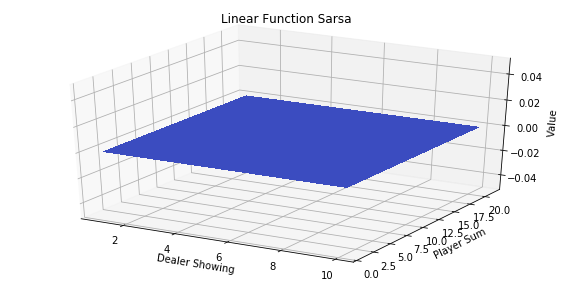

In [256]:
fig = plot_pls("Linear Function Sarsa", LFA_V)
# fig.savefig("LFA-N0=100, Lambda = 1, 1000000 Episodes")

In [28]:
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense

Using TensorFlow backend.


In [29]:
model = Sequential()
model.add(InputLayer(batch_input_shape=(1, 22*11)))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [30]:
def NN_Eval(episode_count, env):
    gamma = 1
    nn_wins = 0
    
    eps = 0.5
    eps_decay_factor = 0.999
    discount_factor = 0.95
    observation_space_n = 22*11
    action_space_n=2
        
    for nn_episode in range(episode_count):              
        s = State(env.deck)
        
        eps *= eps_decay_factor
    
        while not s.is_Terminal:
            state_index = s.player_sum + s.card.value*21
            
            if random.uniform(0, 1) < eps:
                if (random.randint(0,1)):
                    action = 1
                else:
                    action = 0
            else:
                    action = np.argmax(model.predict(np.identity(observation_space_n)[state_index:state_index + 1]))
                    
                    
            next_state, r = env.step(s, action)
            
#             if (not next_state.is_Terminal):
            next_state_index = next_state.player_sum + next_state.card.value*21
            target = r + discount_factor * \
                np.max(model.predict(np.identity(observation_space_n)[next_state_index:next_state_index + 1]))
            target_vector = model.predict(np.identity(observation_space_n)[state_index:state_index + 1])[0]
            target_vector[action] = target
            
            model.fit(
                np.identity(observation_space_n)[state_index:state_index + 1], 
                target_vector.reshape(-1, action_space_n), 
                epochs=1, verbose=0)
            
            
            s = next_state
        #Episode complete
        if (r == 1):
            nn_wins += 1
        if (nn_episode > 30 and nn_episode < 100  and nn_episode != 0):
            print("NN Episode ", nn_episode, " wins/iterations ", (nn_wins/nn_episode * 100))
            
    return     

In [31]:
def main():
    import time

    start = time.time()
    logger = logging.getLogger()
    logger.disabled = True
    
    env = Env(13) 
    episode_c = 100

    MC_V, MC_Q = MC_Eval(episode_c, env)
    MC_time = time.time()
    print("MC time: ", MC_time - start)
    
    TD_V, TD_Q, mse_values = TD_Eval(episode_c, env, MC_Q.copy(), 1)
    TD_time = time.time()
    print("TD time: ", TD_time - MC_time)
    
#     lambdas = [it/10.0 for it in range(0, 11, 1)]
#     mse_episode_count = 1000000
#     mse_values = MSE(mse_episode_count, env, MC_Q.copy(), lambdas)
#     all_mse_values.append(mse_values)

#     LFA_V, LFA_Q, mse_values = LFA_Eval(episode_c, env, MC_Q.copy(), 1)
    LFA_time = time.time()
    print("LFA time: ", LFA_time - TD_time)
    
#     NN_Eval(episode_c, env)
    
    end = time.time()
    print("Total time taken: ", end - start)
    
    return MC_V, MC_Q, TD_V, TD_Q, mse_values, LFA_V, LFA_Q

In [38]:
MC_V, MC_Q, TD_V, TD_Q, mse_values, LFA_V, LFA_Q = main()

print("Done!")

In [142]:
envmc = Env(13) 
episode_c = 50

_, _ = MC_Eval(episode_c, envmc)

In [40]:
env2 = Env(13) 
episode_c = 50

_,_,_ = TD_Eval(episode_c, env2, MC_Q.copy(), 0)

In [41]:
env = Env(13) 
episode_c = 100
_,_,_ = LFA_Eval(episode_c, env, MC_Q.copy(), 1)

In [42]:
env = Env(13) 
episode_c = 100

NN_Eval(episode_c, env)

In [43]:
env = Env(13) 
episode_c = 100
NeuralNet_Self(episode_c, env, "relu")

In [244]:
class NeuralNetwork:
    def __init__(self, x, y, activationFN):
        self.input     = x
        self.y         = y
        self.output    = np.zeros(y.shape)
        self.weights1  = np.random.rand(self.input.shape[1], 4)
        self.weights2  = np.random.rand(4,2)
        
        self.activationFN = activationFN
        self.activationFN_der = activationFN+"_derivative"
        self.functions = {"sigmoid" : self.sigmoid,
                          "sigmoid_derivative" : self.sigmoid_derivative,
                          "relu" : self.relu,
                          "relu_derivative" : self.relu_derivative
                          }
        
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return np.exp(x)/pow((1+np.exp(x)),2)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        arr = copy.copy(x)
        arr[x<=0] = 0
        arr[x>0] = 1
        return arr
        
    def feedForward(self, x):
        self.input  = x
        self.layer1 = self.functions[self.activationFN](np.dot(self.input, self.weights1)) # + bias vector
        self.output = self.functions[self.activationFN](np.dot(self.layer1, self.weights2)) # + bias vector
        return self.output
        
    def backprop(self, target_y):
        self.y = copy.copy(target_y)
        d_weights2 = np.dot(self.layer1.T, (2*(self.y - self.output)* self.functions[self.activationFN_der](self.output)))
        d_weights1 = np.dot(self.input.T, (np.dot(2*(self.y - self.output) * self.functions[self.activationFN_der](self.output), self.weights2.T) * self.functions[self.activationFN_der](self.layer1)))

        self.weights1 += d_weights1
        self.weights2 += d_weights2

In [245]:
def NeuralNet_Self(episode_count, env, activationFunction):
    gamma = 1
    nn_wins = 0
    WRperEpisode = []
    
    eps = 0.5
    eps_decay_factor = 0.999
    discount_factor = 0.95
    observation_space_n = 22*11
    action_space_n=2
    
    x = np.zeros((1, observation_space_n))
    y = np.zeros((1, action_space_n))
    my_NN = NeuralNetwork(x, y, activationFunction)
        
    for nn_episode in range(1, episode_count):              
        s = State(env.deck)
        
        eps *= eps_decay_factor
    
        while not s.is_Terminal:
            state_index = s.player_sum + s.card.value*21
            
            if random.uniform(0, 1) < eps:
                if (random.randint(0,1)):
                    action = 1
                else:
                    action = 0
            else:
                action = np.argmax(my_NN.feedForward(np.identity(observation_space_n)[state_index:state_index + 1]))
                
            next_state, r = env.step(s, action)
            next_state_index = next_state.player_sum + next_state.card.value*21
            
            target = r + discount_factor * \
                np.max(my_NN.feedForward(np.identity(observation_space_n)[next_state_index:next_state_index + 1]))
            
            
            target_vector = my_NN.feedForward(np.identity(observation_space_n)[state_index:state_index + 1])[0]
            target_vector[action] = target
            my_NN.backprop(target_vector)  
            
            s = next_state
            
        #Episode complete
        WRperEpisode.append(nn_wins/nn_episode)
        if (r == 1):
            nn_wins += 1
        if (nn_episode > 30 and nn_episode < 100 and nn_episode != 0):
            pass
#             print("NN-Self Episode ", nn_episode, " wins/iterations ", "{:.2f}".format(nn_wins/nn_episode * 100), "using ", activationFunction)
            
    return (nn_wins/nn_episode * 100.0), WRperEpisode

In [259]:
def self_NN_Test():
    env = Env(50) 
    episode_c = 1000
    
    sigWinPerEpisode = []
    relWinPerEpisode = []

    sigWin, sigWinPerEpisode = NeuralNet_Self(episode_c, env, "sigmoid")
    relWin, relWinPerEpisode = NeuralNet_Self(episode_c, env, "relu")
    
    print("Win rate for sigmoid: ", "{:.4f}".format(sigWin))
    print("Win rate for ReLU   : ", "{:.4f}".format(relWin))
    
    return sigWinPerEpisode, relWinPerEpisode

In [260]:
# 13 is good, 4 is bad for both, 3 is good sigmoid bad ReLU, 30 is bad sigmoid good ReLU
np.random.seed(4)
sigWinPerEpisodeList, relWinPerEpisodeList = self_NN_Test()
sigWinPerEpisode = np.array(sigWinPerEpisodeList) * 100
relWinPerEpisode = np.array(relWinPerEpisodeList) * 100

Win rate for sigmoid:  4.4904
Win rate for ReLU   :  6.4206


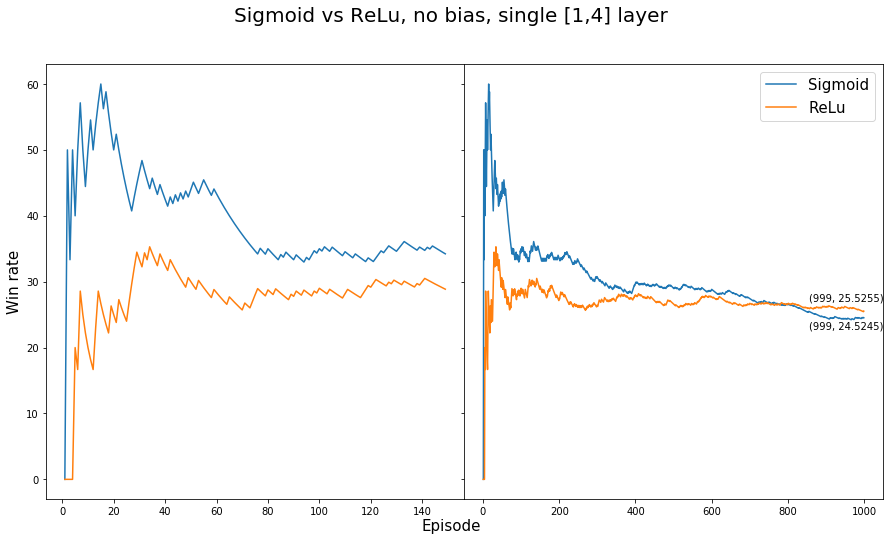

In [258]:
NNFig, axs = plt.subplots(1, 2, sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0},figsize=(15,8))
(ax1, ax2) = axs

ax1.plot(range(1,150), sigWinPerEpisode[0:149],  label="Sigmoid")  
ax1.plot(range(1,150), relWinPerEpisode[0:149], label="ReLu")  
ax2.plot(range(1,1000), sigWinPerEpisode,  label="Sigmoid")  
ax2.plot(range(1,1000), relWinPerEpisode, label="ReLu")  
NNFig.text(0.5, 0.07, 'Episode', ha='center', fontsize=15)
ax1.set_ylabel('Win rate', fontsize=15)  
NNFig.suptitle("Sigmoid vs ReLu, no bias, single [1,4] layer", fontsize=20)  
ax2.legend(fontsize=15)  

for xy in zip(range(1,1000), sigWinPerEpisode): 
    if (xy[0] % 999 == 0):
        ax2.annotate('(%s, %.4f)' % xy, xy=xy, textcoords="offset points", xytext=(-55,-11)) 
            
for xy in zip(range(1,1000), relWinPerEpisode): 
    if (xy[0] % 999 == 0):
        ax2.annotate('(%s, %.4f)' % xy, xy=xy, textcoords="offset points", xytext=(-55,10)) 

In [255]:
# NNFig.savefig("Sigmoid vs ReLu, no bias, single [1,4] layer, 1000 Episodes")